# Exploring key predictors of CS enrollment in Washington state

We will be using the data table at https://github.com/lgtanimoto/WAStateCSEd/blob/main/2022/2022_school_pt.csv created from the 2021-22 CSEd Summary Report published by OSPI which shows for each high school, how many students, how many student enrollments, how many male students, how many male student enrollments, how many female students, how many female student enrollments, how many gender X, how many gender X enrollments, and does similar info for race/ethnicity, FRL status, ELL status, disability status.   Cross-sectional data (e.g. how many black female enrollments) is not available. With this data we will generate 300,000 random student records and then perform PCA analysis to discover key predictors of CS enrollment in Washington state.

First, we need to import the libraries we will need to explore and analyze this data.

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
# import ctgan as ct
# import sdv
#from sdv.single_table import CTGANSynthesizer
#from sdv.datasets.local import load_csvs
#from ctgan import CTGAN
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import datasets
from sklearn.tree import export_graphviz
from io import StringIO  
from IPython.display import Image  
import pydotplus

Then we will upload the data that we will be using to generate random student records.

In [2]:
ospi_data = pd.read_csv('2022_school_pt.csv',  index_col=0)

Let's take a look at the first few records from the csv file to better understand the school records we are working with.

In [3]:
ospi_data.head()

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,...,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12
0,1109,3075,28,3,9,0,19,3,0,0,...,26,3,7,0,4,0,6,1,11,2
1,1147,3015,1281,169,635,60,646,109,0,0,...,1086,140,382,51,328,44,321,29,250,45
2,1158,2903,60,22,30,12,29,10,1,0,...,57,21,18,12,15,2,14,2,13,6
3,1160,2132,113,24,57,13,56,11,0,0,...,107,20,32,7,35,5,25,4,21,8
4,2250,1617,167,0,89,0,78,0,0,0,...,142,0,16,0,51,0,41,0,59,0


In [4]:
len(ospi_data.index)

730

Next we need to make sure the data is clean and suitable for manipulation by searching for missing values. We will handle normalization later, in different ways, depending on the method for synthetic data generation.

In [5]:
num_missing_val = ospi_data.isnull().sum()
num_missing_val.sum()

0

We see that there are no missing values so now we will move on to generating 300,000 random student records with the help of numpy.

To do this, we need to gather the probabilities implied by the given dataset. These probabilities need to be calculated from each of the columns--comparing the total number of students belonging to each feature category to the number that enrolled in a CS course. We also need to find probabilities for which category a single student will belong to.

In [6]:
ospi_data.columns

Index(['DistrictCode', 'SchoolCode', 'AllStudents', 'C_AllStudents',
       'G_Female', 'GC_Female', 'G_Male', 'GC_Male', 'G_GenderX', 'GC_GenderX',
       'R_Native', 'RC_Native', 'R_Asian', 'RC_Asian', 'R_Black', 'RC_Black',
       'R_Hisp_Lat', 'RC_Hisp_Lat', 'R_HPI', 'RC_HPI', 'R_NA', 'RC_NA',
       'R_TwoOrMore', 'RC_TwoOrMore', 'R_White', 'RC_White', 'L_ELL', 'LC_ELL',
       'L_NoELL', 'LC_NoELL', 'I_LowIncome', 'IC_LowIncome', 'I_NoLowIncome',
       'IC_NOLowIncome', 'D_Disability', 'DC_Disability', 'D_NoDisability',
       'DC_NoDisability', 'A_9', 'AC_9', 'A_10', 'AC_10', 'A_11', 'AC_11',
       'A_12', 'AC_12'],
      dtype='object')

An interesting consideration to begin with is looking at the ratio of all students who enroll in CS:

In [7]:
sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents)

0.07654341235652434

This shows that about 7.65% of all students in this dataset enrolled in CS. 

Now, let's go through each of the columns to assign probabilities to every category of student.

In [8]:
Prob_GC_Female = sum(ospi_data.GC_Female) / sum(ospi_data.G_Female)
Prob_GC_Male = sum(ospi_data.GC_Male) / sum(ospi_data.G_Male)
Prob_GC_GenderX = sum(ospi_data.GC_GenderX) / sum(ospi_data.G_GenderX)
Prob_RC_Native = sum(ospi_data.RC_Native) / sum(ospi_data.R_Native)
Prob_RC_Asian = sum(ospi_data.RC_Asian) / sum(ospi_data.R_Asian)
Prob_RC_Black = sum(ospi_data.RC_Black) / sum(ospi_data.R_Black)
Prob_RC_Hisp_Lat = sum(ospi_data.RC_Hisp_Lat) / sum(ospi_data.R_Hisp_Lat)
Prob_RC_HPI = sum(ospi_data.RC_HPI) / sum(ospi_data.R_HPI)
Prob_RC_NA = sum(ospi_data.RC_NA) / sum(ospi_data.R_NA)
Prob_RC_TwoOrMore = sum(ospi_data.RC_TwoOrMore) / sum(ospi_data.R_TwoOrMore)
Prob_RC_White = sum(ospi_data.RC_White) / sum(ospi_data.R_White)
Prob_LC_ELL = sum(ospi_data.LC_ELL) / sum(ospi_data.L_ELL)
Prob_LC_NoELL = sum(ospi_data.LC_NoELL) / sum(ospi_data.L_NoELL)
Prob_IC_LowIncome = sum(ospi_data.IC_LowIncome) / sum(ospi_data.I_LowIncome)
Prob_IC_NoLowIncome = sum(ospi_data.IC_NOLowIncome) / sum(ospi_data.I_NoLowIncome)
Prob_DC_Disability = sum(ospi_data.DC_Disability) / sum(ospi_data.D_Disability)
Prob_DC_NoDisability = sum(ospi_data.DC_NoDisability) / sum(ospi_data.D_NoDisability)
Prob_AC_9 = sum(ospi_data.AC_9) / sum(ospi_data.A_9)
Prob_AC_10 = sum(ospi_data.AC_10) / sum(ospi_data.A_10)
Prob_AC_11 = sum(ospi_data.AC_11) / sum(ospi_data.A_11)
Prob_AC_12 = sum(ospi_data.AC_12) / sum(ospi_data.A_12)

There's more work to do but let's pause and notice that we can now easily compare probabilities, like for gender:

In [9]:
print(Prob_GC_Female)
print(Prob_GC_Male)
print(Prob_GC_GenderX)

0.04510418114369407
0.10592888529774107
0.07277526395173455


These numbers suggest that there's more than double the probability that a male student will enroll in a CS course versus a female student. Also interesting to note is that a student identifying as GenderX has a higher probability of enrolling than a female student. However, this probability may not be completely realistic because there are far fewer students who identify as GenderX, compared to male or female.

In [10]:
print(sum(ospi_data.G_Female))
print(sum(ospi_data.G_Male))
print(sum(ospi_data.G_GenderX))

187078
200493
2652


Next we will find probabilities for which category a student will belong to.

In [11]:
Prob_G_Female = sum(ospi_data.G_Female) / sum(ospi_data.AllStudents)
Prob_G_Male = sum(ospi_data.G_Male) / sum(ospi_data.AllStudents)
Prob_G_GenderX = sum(ospi_data.G_GenderX) / sum(ospi_data.AllStudents)
Prob_R_Native = sum(ospi_data.R_Native) / sum(ospi_data.AllStudents)
Prob_R_Asian = sum(ospi_data.R_Asian) / sum(ospi_data.AllStudents)
Prob_R_Black = sum(ospi_data.R_Black) / sum(ospi_data.AllStudents)
Prob_R_Hisp_Lat = sum(ospi_data.R_Hisp_Lat) / sum(ospi_data.AllStudents)
Prob_R_HPI = sum(ospi_data.R_HPI) / sum(ospi_data.AllStudents)
Prob_R_NA = sum(ospi_data.R_NA) / sum(ospi_data.AllStudents)
Prob_R_TwoOrMore = sum(ospi_data.R_TwoOrMore) / sum(ospi_data.AllStudents)
Prob_R_White = sum(ospi_data.R_White) / sum(ospi_data.AllStudents)
Prob_L_ELL = sum(ospi_data.L_ELL) / sum(ospi_data.AllStudents)
Prob_I_LowIncome = sum(ospi_data.I_LowIncome) / sum(ospi_data.AllStudents)
Prob_I_NoLowIncome = sum(ospi_data.I_NoLowIncome) / sum(ospi_data.AllStudents)
Prob_D_Disability = sum(ospi_data.D_Disability) / sum(ospi_data.AllStudents)
Prob_D_NoDisability = sum(ospi_data.D_NoDisability) / sum(ospi_data.AllStudents)
Prob_A_9 = sum(ospi_data.A_9) / sum(ospi_data.AllStudents)
Prob_A_10 = sum(ospi_data.A_10) / sum(ospi_data.AllStudents)
Prob_A_11 = sum(ospi_data.A_11) / sum(ospi_data.AllStudents)
Prob_A_12 = sum(ospi_data.A_12) / sum(ospi_data.AllStudents)

Now, we can use these probabilities to begin creating a synthetic dataset of student records. Let's start with gender.

In [12]:
rng = np.random.default_rng(seed=6525)

# How many student records we want to generate

num_students = 400000

# Load and normalize probabilities
# Gender

g_probs = np.array([Prob_G_Female, Prob_G_Male, Prob_G_GenderX])
g_probs /= np.sum(g_probs)

# Race

r_probs = np.array([Prob_R_Native, Prob_R_Asian, Prob_R_Black, Prob_R_Hisp_Lat, Prob_R_HPI, Prob_R_NA, Prob_R_TwoOrMore, Prob_R_White])
r_probs /= np.sum(r_probs)

# ELL

e_probs = np.array([1-Prob_L_ELL, Prob_L_ELL])

# Income

i_probs = np.array([Prob_I_NoLowIncome, Prob_I_LowIncome])

# Disability

d_probs = np.array([Prob_D_NoDisability, Prob_D_Disability])

# Grade

a_probs = np.array([Prob_A_9, Prob_A_10, Prob_A_11, Prob_A_12])
a_probs /= np.sum(a_probs)

# Generate values for categorical attributes

rng = np.random.default_rng()
gender = rng.choice(['female', 'male', 'x'], size = num_students, p = g_probs)
race = rng.choice(['Native', 'Asian', 'Black', 'Hisp_Lat', 'HPI', 'NA', 'TwoOrMore', 'White'], size = num_students, p = r_probs)
ell = rng.choice([0, 1], size = num_students, p = e_probs)
income = rng.choice([0, 1], size = num_students, p = i_probs)
disability = rng.choice([0, 1], size = num_students, p = d_probs)
grade = rng.choice(['9', '10', '11', '12'], size = num_students, p = a_probs)

# Print the first few synthetic data points to ensure that this is working as expected
print(gender[:10])
print(race[:10])
print(ell[:10])
print(income[:10])
print(disability[:10])
print(grade[:10])

['male' 'female' 'female' 'male' 'male' 'female' 'female' 'male' 'male'
 'male']
['Hisp_Lat' 'White' 'TwoOrMore' 'White' 'White' 'White' 'White' 'Hisp_Lat'
 'White' 'TwoOrMore']
[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 1 1 0 1 0]
[1 0 0 0 0 0 0 0 0 0]
['9' '10' '12' '9' '9' '10' '12' '12' '11' '11']


Let's create a dataframe to hold these new records and add what we've generated as columns.

In [13]:
synth_students = pd.DataFrame()
synth_students.insert(0, "Gender", gender, True)
synth_students.insert(1, "Race", race, True)
synth_students.insert(2, "ELL", ell, True)
synth_students.insert(3, "Low Income", income, True)
synth_students.insert(4, "Disability", disability, True)
synth_students.insert(5, "Grade", grade, True)

After that we can take a look at some of our student records.

In [14]:
synth_students.head()

,Gender,Race,ELL,Low Income,Disability,Grade
0,male,Hisp_Lat,0,1,1,9
1,female,White,0,1,0,10
2,female,TwoOrMore,0,1,0,12
3,male,White,0,1,0,9
4,male,White,0,0,0,9


In [15]:
synth_students.tail()

,Gender,Race,ELL,Low Income,Disability,Grade
399995,male,Hisp_Lat,0,0,0,9
399996,female,White,0,0,0,10
399997,male,Hisp_Lat,0,1,0,10
399998,female,White,0,0,1,10
399999,female,Black,0,1,1,11


One thing is missing from this synthetic data--whether or not each synthesized student is enrolled in CS. Creating this column will be a little more complex than the previous because we need to use the probabilities of the column values of each row to calculate whether or not the synthesized student is enrolled in CS.

In order to do this, let's convert all of those synthesized student column values into probabilities that they will be enrolled in CS. E.g. if a column value is "Hisp_Lat" then replace it with the variable Prob_RC_Hisp_Lat that we created earlier.

In [16]:
synth_students.replace("Hisp_Lat", Prob_RC_Hisp_Lat)

,Gender,Race,ELL,Low Income,Disability,Grade
0,male,0.066245,0,1,1,9
1,female,White,0,1,0,10
2,female,TwoOrMore,0,1,0,12
3,male,White,0,1,0,9
4,male,White,0,0,0,9
...,...,...,...,...,...,...
399995,male,0.066245,0,0,0,9
399996,female,White,0,0,0,10
399997,male,0.066245,0,1,0,10
399998,female,White,0,0,1,10


Now, we'll do this for each variable.

In [17]:
synth_students.replace("Hisp_Lat", Prob_RC_Hisp_Lat)

,Gender,Race,ELL,Low Income,Disability,Grade
0,male,0.066245,0,1,1,9
1,female,White,0,1,0,10
2,female,TwoOrMore,0,1,0,12
3,male,White,0,1,0,9
4,male,White,0,0,0,9
...,...,...,...,...,...,...
399995,male,0.066245,0,0,0,9
399996,female,White,0,0,0,10
399997,male,0.066245,0,1,0,10
399998,female,White,0,0,1,10


But it's not best practice to manipulate the dataframe we have. Instead we should create a new dataframe. There are a few ways to do this. Today we will create a new dataframe out of each column, replace(1) values with the associated probabilities, and then bring them back together in a dataframe so that we can calculate our final column of whether or not the student is enrolled in CS.

1: We are using the attribute "inplace=True" to actually manipulate the new dataframes we create out of the columns. In the previous example we did not use this attribute so the dataframe was not actually changed. 

In [18]:
ell_df = synth_students[['ELL']].copy()

In [19]:
ell_df.replace(1, Prob_LC_ELL, inplace=True)
ell_df.head()

,ELL
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [20]:
zero_prob = Prob_LC_NoELL
ell_df.replace(0, zero_prob, inplace=True)
ell_df.head()

,ELL
0,0.078064
1,0.078064
2,0.078064
3,0.078064
4,0.078064


In [21]:
gend_df = synth_students[['Gender']].copy()
race_df = synth_students[['Race']].copy()
inc_df = synth_students[['Low Income']].copy()
dis_df = synth_students[['Disability']].copy()
gr_df = synth_students[['Grade']].copy()

In [22]:
gend_df.replace('male', Prob_GC_Male, inplace=True)
gend_df.replace('female', Prob_GC_Female, inplace=True)
gend_df.replace('x', Prob_GC_GenderX, inplace=True)
gend_df.head()

,Gender
0,0.105929
1,0.045104
2,0.045104
3,0.105929
4,0.105929


In [23]:
race_df.replace('Native', Prob_RC_Native, inplace=True)
race_df.replace('Asian', Prob_RC_Asian, inplace=True)
race_df.replace('Black', Prob_RC_Black, inplace=True)
race_df.replace('Hisp_Lat', Prob_RC_Hisp_Lat, inplace=True)
race_df.replace('HPI', Prob_RC_HPI, inplace=True)
race_df.replace('NA', Prob_RC_NA, inplace=True)
race_df.replace('TwoOrMore', Prob_RC_TwoOrMore, inplace=True)
race_df.replace('White', Prob_RC_White, inplace=True)
race_df.head()

,Race
0,0.066245
1,0.072356
2,0.075342
3,0.072356
4,0.072356


In [24]:
inc_df.replace(0, Prob_IC_NoLowIncome, inplace=True)
inc_df.replace(1, Prob_IC_LowIncome, inplace=True)
inc_df.head()

,Low Income
0,0.067853
1,0.067853
2,0.067853
3,0.067853
4,0.083896


In [25]:
dis_df.replace(0, Prob_DC_NoDisability, inplace=True)
dis_df.replace(1, Prob_DC_Disability, inplace=True)
dis_df.head()

,Disability
0,0.056698
1,0.079513
2,0.079513
3,0.079513
4,0.079513


In [26]:
gr_df.replace('9', Prob_AC_9, inplace=True)
gr_df.replace('10', Prob_AC_10, inplace=True)
gr_df.replace('11', Prob_AC_11, inplace=True)
gr_df.replace('12', Prob_AC_12, inplace=True)
gr_df.head()

,Grade
0,0.103522
1,0.079958
2,0.061673
3,0.103522
4,0.103522


After all of the columns have had their values replaced with probabilities we need to bring them all together in a single dataframe to calculate the probability of enrollment in CS based on those proabibilities. 

In [27]:
calc_prob = pd.DataFrame()
calc_prob["Gender"] = gend_df
calc_prob["Race"] = race_df
calc_prob["ELL"] = ell_df
calc_prob["Income"] = inc_df
calc_prob["Disability"] = dis_df
calc_prob["Grade"] = gr_df
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade
0,0.105929,0.066245,0.078064,0.067853,0.056698,0.103522
1,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958
2,0.045104,0.075342,0.078064,0.067853,0.079513,0.061673
3,0.105929,0.072356,0.078064,0.067853,0.079513,0.103522
4,0.105929,0.072356,0.078064,0.083896,0.079513,0.103522


To do this we will need a function to calculate the probability of CS enrollment for each row but are missing important information for conditional probabilities--we know the probability of whether or not somebody enrolls in CS because of one feature, but not multiple features. No cross-sectional or intersectional data is available. So instead we will calculate CS enrollment three ways and decide which is best for our use case. 

In [28]:
def calc_m1_prob(row):
    return min(row['Gender'], row['Race'], row['ELL'], row['Income'], row['Disability'], row['Grade'])


calc_prob['M1_Prob'] = calc_prob.apply(calc_m1_prob, axis=1)


def is_cs_m1(prob):
    return np.random.choice([0, 1], p=[1 - prob, prob])

calc_prob['CS_M1'] = calc_prob['M1_Prob'].apply(is_cs_m1)
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1
0,0.105929,0.066245,0.078064,0.067853,0.056698,0.103522,0.056698,0
1,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958,0.045104,0
2,0.045104,0.075342,0.078064,0.067853,0.079513,0.061673,0.045104,0
3,0.105929,0.072356,0.078064,0.067853,0.079513,0.103522,0.067853,0
4,0.105929,0.072356,0.078064,0.083896,0.079513,0.103522,0.072356,0


Another possible method would be to use the probability found from all students, not taking features into account.

In [29]:
Prob_All = sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents)
a_probs = np.array([1-Prob_All, Prob_All])
CS_M2 = rng.choice([0, 1], size = num_students, p = a_probs)
calc_prob.insert(8, "CS_M2", CS_M2, True)
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2
0,0.105929,0.066245,0.078064,0.067853,0.056698,0.103522,0.056698,0,0
1,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958,0.045104,0,1
2,0.045104,0.075342,0.078064,0.067853,0.079513,0.061673,0.045104,0,0
3,0.105929,0.072356,0.078064,0.067853,0.079513,0.103522,0.067853,0,0
4,0.105929,0.072356,0.078064,0.083896,0.079513,0.103522,0.072356,0,1


A third method would be to average the probabilities taken from the synthesized student's features.

In [30]:
def calc_m3_prob(row):
    return (row['Gender'] + row['Race'] + row['ELL'] + row['Income'] + row['Disability'] + row['Grade']) / 6


calc_prob['M3_Prob'] = calc_prob.apply(calc_m3_prob, axis=1)


def is_cs_m3(prob):
    return np.random.choice([0, 1], p=[1 - prob, prob])

calc_prob['CS_M3'] = calc_prob['M3_Prob'].apply(is_cs_m3)
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2,M3_Prob,CS_M3
0,0.105929,0.066245,0.078064,0.067853,0.056698,0.103522,0.056698,0,0,0.079718,1
1,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958,0.045104,0,1,0.070475,0
2,0.045104,0.075342,0.078064,0.067853,0.079513,0.061673,0.045104,0,0,0.067925,0
3,0.105929,0.072356,0.078064,0.067853,0.079513,0.103522,0.067853,0,0,0.084539,1
4,0.105929,0.072356,0.078064,0.083896,0.079513,0.103522,0.072356,0,1,0.087213,0


Let's compare the different percentages of CS enrollment between methods and the sample data.

In [31]:
pct_All_CS_synth1 = f"{sum(calc_prob['CS_M1']) / num_students:%}"
pct_All_CS_synth2 = f"{sum(calc_prob['CS_M2']) / num_students:%}"
pct_All_CS_synth3 = f"{sum(calc_prob['CS_M3']) / num_students:%}"
pct_All_CS_ospi = f"{sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents):%}"
print("Method 1:", pct_All_CS_synth1)
print("Method 2:",pct_All_CS_synth2)
print("Method 3:",pct_All_CS_synth3)
print("OSPI Data:",pct_All_CS_ospi)

Method 1: 5.455000%
Method 2: 7.630250%
Method 3: 7.666500%
OSPI Data: 7.654341%


Method 3 appears to yield the closest results.

To better understand how to do this we can explore the data further. Three ways we will look deeper into this data:

- Combine the probability dataframe with the binary data frame so we can look at these together and make sense of them within each synthetic student. Picking the minimum or average may not be the answer, maybe some probabilities should be weighted? Is the random generator ensuring we aren't creating bias in the PCA we want to later perform?
- Make up the missing percentages between Method 1 and sample data using another random method.
- Divide students by school. This may result in richer analysis, anyway, so we will pursue this option as well for PCA.

In [32]:
all_synth = pd.concat([synth_students, calc_prob], axis=1)
all_synth.head(25)

,Gender,Race,ELL,Low Income,Disability,Grade,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2,M3_Prob,CS_M3
0,male,Hisp_Lat,0,1,1,9,0.105929,0.066245,0.078064,0.067853,0.056698,0.103522,0.056698,0,0,0.079718,1
1,female,White,0,1,0,10,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958,0.045104,0,1,0.070475,0
2,female,TwoOrMore,0,1,0,12,0.045104,0.075342,0.078064,0.067853,0.079513,0.061673,0.045104,0,0,0.067925,0
3,male,White,0,1,0,9,0.105929,0.072356,0.078064,0.067853,0.079513,0.103522,0.067853,0,0,0.084539,1
4,male,White,0,0,0,9,0.105929,0.072356,0.078064,0.083896,0.079513,0.103522,0.072356,0,1,0.087213,0
5,female,White,0,1,0,10,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958,0.045104,0,0,0.070475,0
6,female,White,0,1,0,12,0.045104,0.072356,0.078064,0.067853,0.079513,0.061673,0.045104,0,0,0.067427,0
7,male,Hisp_Lat,0,0,0,12,0.105929,0.066245,0.078064,0.083896,0.079513,0.061673,0.061673,0,1,0.079220,0
8,male,White,0,1,0,11,0.105929,0.072356,0.078064,0.067853,0.079513,0.061897,0.061897,0,0,0.077602,0
9,male,TwoOrMore,0,0,0,11,0.105929,0.075342,0.078064,0.083896,0.079513,0.061897,0.061897,0,0,0.080774,0


After we've created this last column, we can create our final dataset that will be ready for PCA. One way to prepare this dataset is making all columns binary. This will make analysis simpler (TODO: reword this)

In [33]:
binary_gender = pd.get_dummies(synth_students['Gender'])
binary_gender.head()

,female,male,x
0,0,1,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


In [34]:
binary_race = pd.get_dummies(synth_students['Race'])
binary_race.head()

,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White
0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1


In [35]:
binary_grade = pd.get_dummies(synth_students['Grade'])
binary_grade.head()

,10,11,12,9
0,0,0,0,1
1,1,0,0,0
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1


Then concatenate these new columns with the existing synth_students dataframe and drop the non-binary ones.

In [36]:
binary_synth = pd.concat([synth_students, binary_gender, binary_race, binary_grade, calc_prob['CS_M1'], calc_prob['CS_M2'], calc_prob['CS_M3']], axis=1)
binary_synth = binary_synth.drop('Gender', axis=1)
binary_synth = binary_synth.drop('Race', axis=1)
binary_synth = binary_synth.drop('Grade', axis=1)

binary_synth.head(25)

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,...,Native,TwoOrMore,White,10,11,12,9,CS_M1,CS_M2,CS_M3
0,0,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
5,0,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
6,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
7,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
8,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


Next, we will do this process again but maintaining the grouping of students by school. To do this we need to create a function that will do what we've done above for each row in our original dataframe from our sample data.

In [37]:
# ospi_data.columns

In [38]:
# synth_school = ospi_data.copy()
# synth_probs = pd.DataFrame()



# features = ['G_Female', 'G_Male',
#        'G_GenderX', 'R_Native', 'R_Asian',
#        'R_Black', 'R_Hisp_Lat', 'R_HPI',
#        'R_NA', 'R_TwoOrMore', 'R_White',
#        'L_ELL', 'L_NoELL', 'I_LowIncome',
#        'I_NoLowIncome', 'D_Disability',
#        'D_NoDisability','A_9',
#        'A_10', 'A_11', 'A_12']

# cs_features = ['GC_Female', 'GC_Male',
#        'GC_GenderX', 'RC_Native','RC_Asian',
#        'RC_Black', 'RC_Hisp_Lat', 'RC_HPI',
#        'RC_NA', 'RC_TwoOrMore', 'RC_White',
#        'LC_ELL', 'LC_NoELL', 'IC_LowIncome', 
#        'IC_NOLowIncome', 'DC_Disability',
#        'DC_NoDisability', 'AC_9',
#        'AC_10', 'AC_11', 'AC_12']

# for feature in features:
#     synth_probs[feature] = synth_school.apply(lambda row: row[feature] / row['AllStudents'], axis=1)

    
# for cs_feature, feature in zip(cs_features, features):
#     synth_probs[cs_feature] = synth_school.apply(lambda row, c=cs_feature, f=feature: row[c] / row[f] if row[f] != 0 else np.nan, axis=1)
    
# synth_probs.head(25)
    

In [39]:
# allstudents_df = synth_school[['AllStudents']].copy()
# synth_probs['AllStudents'] = allstudents_df
# synth_probs.head()

In [40]:


# synth_sch_stu = pd.concat([synth_probs.loc[synth_probs.index.repeat(synth_probs['AllStudents'])].reset_index(drop=True),
#                         synth_probs['AllStudents'].repeat(synth_probs['AllStudents']).reset_index(drop=True).rename('AllStudents')], axis=1)


# synth_sch_stu.head(50)

In [41]:
# synth_sch_stu = synth_sch_stu.drop('AllStudents', axis=1)
# synth_sch_stu_a = synth_sch_stu.drop(['GC_Female', 'GC_Male',
#        'GC_GenderX', 'RC_Native','RC_Asian',
#        'RC_Black', 'RC_Hisp_Lat', 'RC_HPI',
#        'RC_NA', 'RC_TwoOrMore', 'RC_White',
#        'LC_ELL', 'LC_NoELL', 'IC_LowIncome', 
#        'IC_NOLowIncome', 'DC_Disability',
#        'DC_NoDisability', 'AC_9',
#        'AC_10', 'AC_11', 'AC_12'], axis=1)
# synth_sch_stu_a.head()

In [42]:
# def is_feature(prob):
#     if np.isnan(prob):
#         return np.nan
#     else:
#         return np.random.choice([0, 1], p=[1 - prob, prob])
    
# binary_synth_sch_a = synth_sch_stu_a.applymap(is_feature)

# binary_synth_sch_a.head(50)

## Decision Tree

We need to denote the independent and dependent variables. We can use the column names and remove the CS enrollment columns for our features list.

In [43]:
student_features = list(binary_synth.columns)
print(student_features)

['ELL', 'Low Income', 'Disability', 'female', 'male', 'x', 'Asian', 'Black', 'HPI', 'Hisp_Lat', 'NA', 'Native', 'TwoOrMore', 'White', '10', '11', '12', '9', 'CS_M1', 'CS_M2', 'CS_M3']


In [44]:
student_features.remove('CS_M1')
student_features.remove('CS_M2')
student_features.remove('CS_M3')
print(student_features)

['ELL', 'Low Income', 'Disability', 'female', 'male', 'x', 'Asian', 'Black', 'HPI', 'Hisp_Lat', 'NA', 'Native', 'TwoOrMore', 'White', '10', '11', '12', '9']


And, of course, we have CS enrollment as the dependent variable. We will assign these to x and y variables. In this first round we will concentrate on our first generated dataset and use the third method as our dependent variable (later we can do the same with M1 and M2 and compare).

In [45]:
x = binary_synth[student_features]
y = binary_synth.CS_M3

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [47]:
clf = DecisionTreeClassifier(max_depth = 10, min_samples_split = 10)

clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

In [60]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = student_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('WA_CS_Students_M3.png')
Image(graph.create_png())

NameError: name 'StringIO' is not defined

There are two issues with the above image: it is difficult to pick out key indicators and there is a possibility of overfitting. However, if the max_depth or min_samples_split are any less then there are zero students classified as "1" for CS enrollment. We will try a tree with less depth but know that there will only be students classified as "0" in our results. Is there still a way to make this meaningful? Maybe we instead have indicators for not enrolling in CS?

In [48]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.923225


This appears to be a good score, but a confusion matrix will reveal a lot more information about the success of the decision tree classifier.

Confusion matrix

 [[110787      0]
 [  9213      0]]


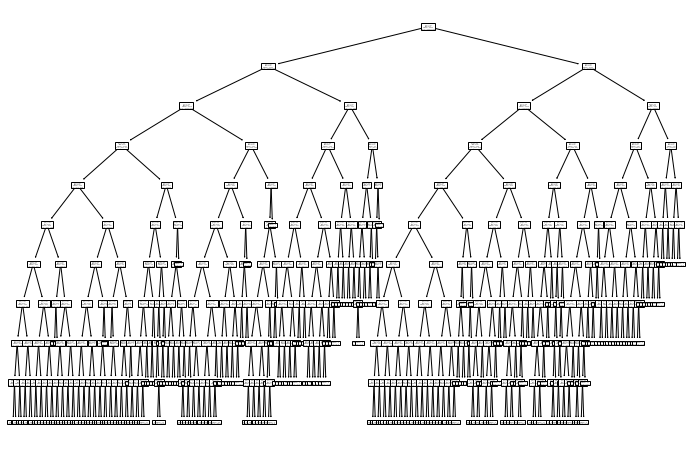

In [51]:

plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(x_train, y_train))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

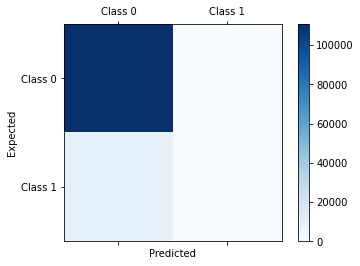

In [62]:
import warnings
warnings.filterwarnings('ignore')

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Here we can see that the accuracy is actually not great. There are not any false positives and plenty of true positives, but there are quite a few false negatives and zero true negatives. To further help describe what this means--a true positive in this context would mean 

Furthermore, it appears that the issue here is that the dataset's classes are imbalanced. If you consider the accuracy score of ~92% and recall that a 7.65% of students were enrolled in CS this imbalance begins to make sense. This has fallen to the [Accuracy Paradox](https://towardsdatascience.com/accuracy-paradox-897a69e2dd9b). What happens is that the algorithm, understandably, decides to just predict one class and voila--high accuracy is acheived because one class is present over 90% of the time! 

To work around this issue we will balance the classes using undersampling methods (undersampling is recommended when a dataset has hundreds of thousands of records versus oversampling which is better for problems with less data). We will undersample with the more simple sample package and then with the imbalanced-learn module.  Then we will test a few different class ratios.

### Undersampling

First, let's look at the current ratio of our dataset's classes.

Class 0: 369334
Class 1: 30666
Proportion: 12.04 : 1


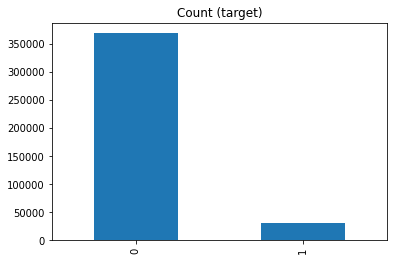

In [80]:
undersample_bisynth = binary_synth.copy(deep=False)
undersample_bisynth = undersample_bisynth.drop(['CS_M1', 'CS_M2'], axis=1)

target_count = undersample_bisynth.CS_M3.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [81]:
undersample_bisynth.head()

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9,CS_M3
0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Random under-sampling:
0    30666
1    30666
Name: CS_M3, dtype: int64


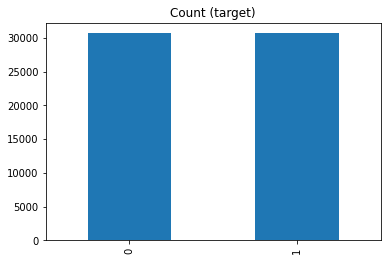

In [82]:
count_class_0, count_class_1 = undersample_bisynth.CS_M3.value_counts()

df_class_0 = undersample_bisynth[undersample_bisynth['CS_M3'] == 0]
df_class_1 = undersample_bisynth[undersample_bisynth['CS_M3'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.CS_M3.value_counts())

df_test_under.CS_M3.value_counts().plot(kind='bar', title='Count (target)');

In [83]:
df_test_under.head()

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9,CS_M3
336162,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
240938,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
268484,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
157576,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
228008,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0


## Random Forest

## Logistic Regression

## Heatmap